# Startup

In [1]:
from importlib import reload
from datetime import date
from os import path, makedirs

import numpy as np
import matplotlib.pyplot as plt
# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.operators.crossover.sbx import SBX
# from pymoo.operators.mutation.pm import PM
# from pymoo.operators.sampling.rnd import FloatRandomSampling
# from pymoo.termination import get_termination
# from pymoo.optimize import minimize
# from pymoo.core.problem import Problem
# import pandas as pd
# import plotly.express as px

# from cam_class_optimization import CamGeneration
import cam_class_optimization
from cam_class_optimization import CamGeneration

# Define problem parameters. Forces are in Newtons, lengths are in meters.
angle_data = 'data/Knee-angle_Chugo_2006.csv'
user_height = 1.654 # 1.654 is avg. height of subjects 55+ in NHANES 2017-2020
k_elastic = 200
sit_angle_deg = 220
offset_angle_deg = 180
target_force_max = 200
target_force_range = 25
target_percentage_max = 32.5
target_percentage_range = 5
target_sitting_max = 25
target_radius_max = 0.0635
dateStr = date.today().strftime("%Y-%m-%d")

# Designate location of standing and storage cam point clouds
folder_path = 'results/cam_plots/cam_plots_2024-06-13_K=100/'
cam_idx = 63

# Junk code for CamGeneration init
x = np.ones(17)
gear_ratios = x[: 8]
input_angles = x[8 : -1]
scaling = x[-1]

INTIAL GUESS PATH LENGTH: 0.08233084376701144
INITIAL GUESS OBJECTIVE VALUE: 2.7619474434084552e-05


<Figure size 640x480 with 0 Axes>

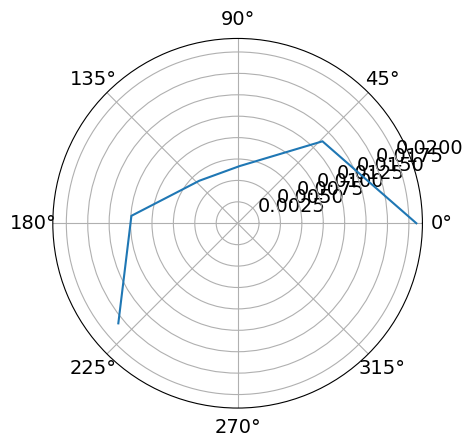

Optimization iteration 10. Objective = 0.006842587528188976
Standing path length: 0.05031329341317365
Current path length: 2.101018758236856


<Figure size 640x480 with 0 Axes>

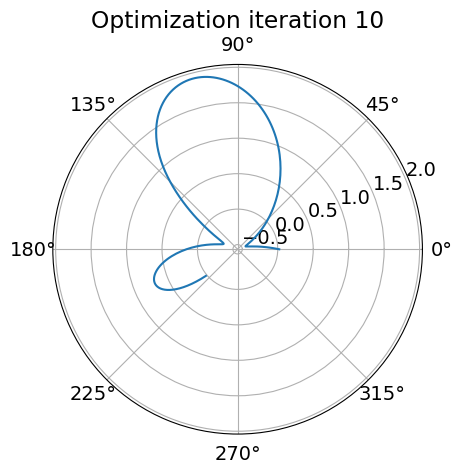

Optimization iteration 20. Objective = 5.499173056599728e-05
Standing path length: 0.05031329341317365
Current path length: 0.06115099210620507


<Figure size 640x480 with 0 Axes>

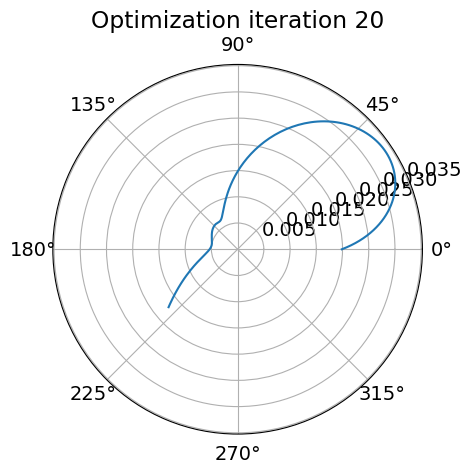

Optimization iteration 30. Objective = 0.0002516980085258301
Standing path length: 0.05031329341317365
Current path length: 0.2159006664348087


<Figure size 640x480 with 0 Axes>

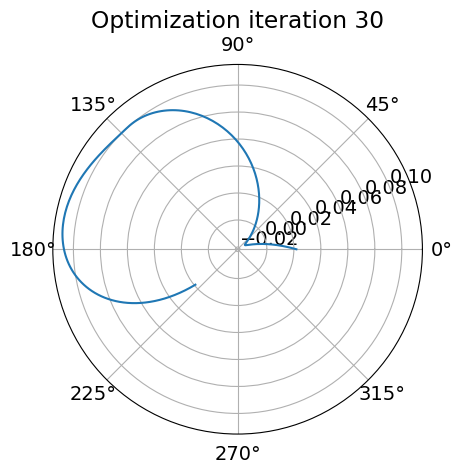

Optimization iteration 40. Objective = 0.008031462731545199
Standing path length: 0.05031329341317365
Current path length: -1.591515478523776


<Figure size 640x480 with 0 Axes>

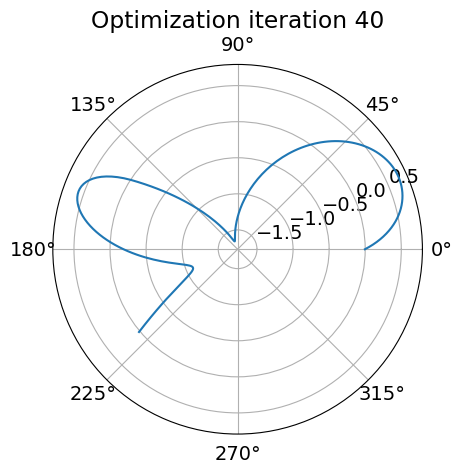

Optimization iteration 50. Objective = 0.0010340120564571464
Standing path length: 0.05031329341317365
Current path length: -0.13920908941540325


<Figure size 640x480 with 0 Axes>

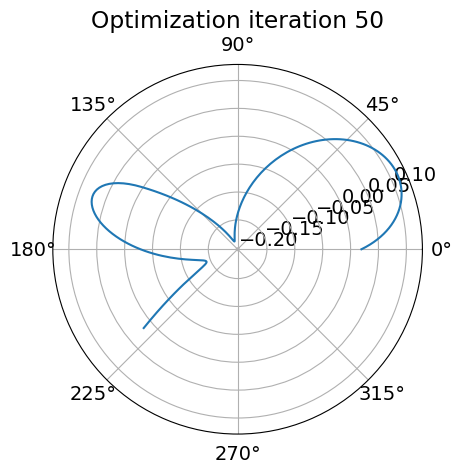

Optimization iteration 60. Objective = 7.898581202669833e-05
Standing path length: 0.05031329341317365
Current path length: 0.058648865134638975


<Figure size 640x480 with 0 Axes>

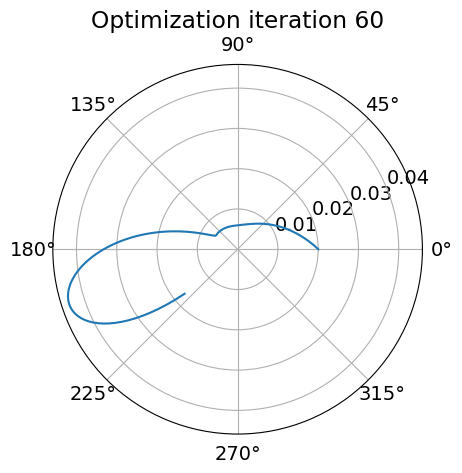

Optimization iteration 70. Objective = 0.0006056757536820706
Standing path length: 0.05031329341317365
Current path length: 0.18018993632517527


<Figure size 640x480 with 0 Axes>

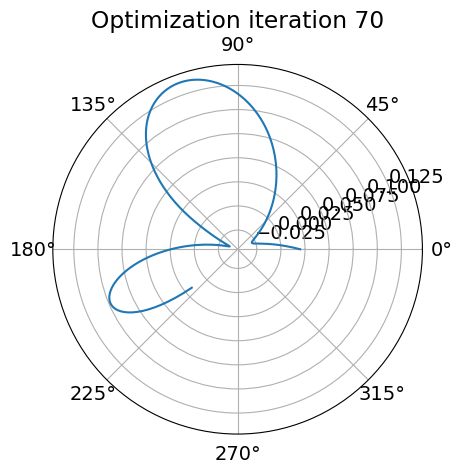

Optimization iteration 80. Objective = 5.0771118705044816e-05
Standing path length: 0.05031329341317365
Current path length: 0.05618079265187032


<Figure size 640x480 with 0 Axes>

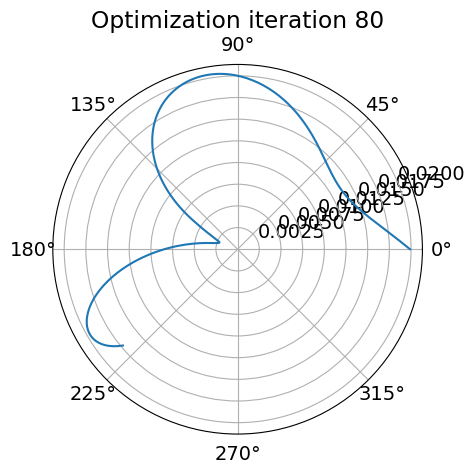

Optimization iteration 90. Objective = 9.688123351010434e-05
Standing path length: 0.05031329341317365
Current path length: 0.0619899623418003


<Figure size 640x480 with 0 Axes>

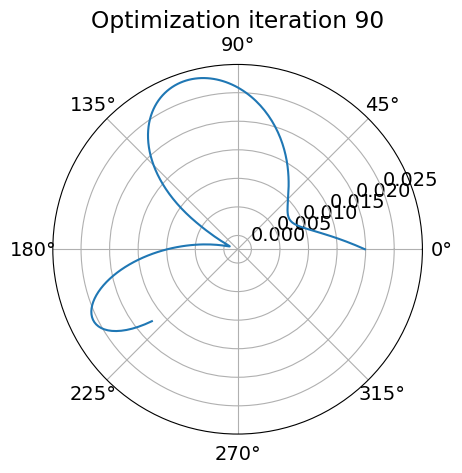

Optimization iteration 100. Objective = 2.441329836878272e-05
Standing path length: 0.05031329341317365
Current path length: 0.042957717617103194


<Figure size 640x480 with 0 Axes>

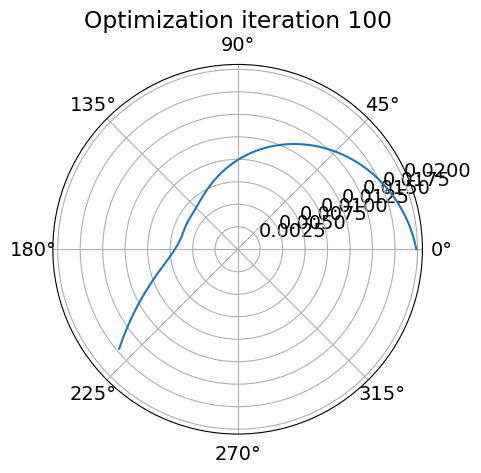

Optimization iteration 110. Objective = 2.756967798570552e-05
Standing path length: 0.05031329341317365
Current path length: 0.04760384872561815


<Figure size 640x480 with 0 Axes>

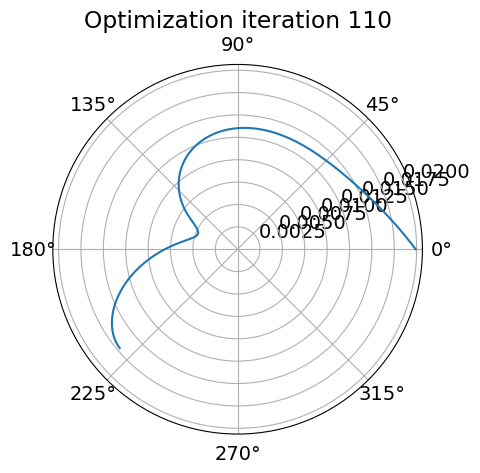

Optimization iteration 120. Objective = 2.4354954538972093e-05
Standing path length: 0.05031329341317365
Current path length: 0.0429577475477551


<Figure size 640x480 with 0 Axes>

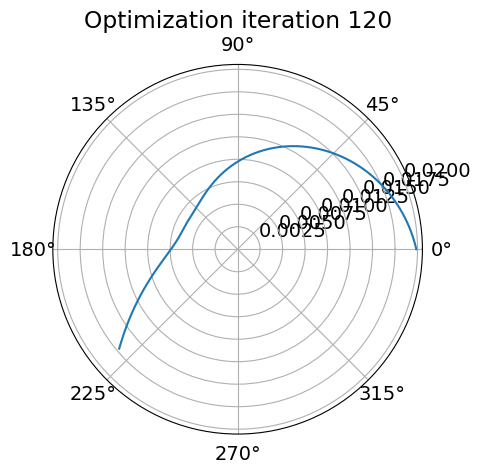

Sit cam path length:  0.04291773087614974
Sit cam start radius:  0.019868667217673767
Sit cam end radius:  0.017183945021141345


<Figure size 640x480 with 0 Axes>

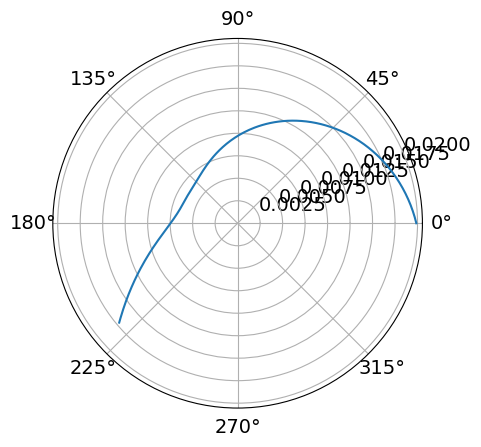

check it out


In [3]:
reload(cam_class_optimization)
from cam_class_optimization import CamGeneration
Cam = CamGeneration(gear_ratios, input_angles, scaling,
                    sit_angle=np.pi/180*sit_angle_deg,
                    offset_angle=np.pi/180*offset_angle_deg)

n_params = 6
result = Cam.generate_sit_cam(folder_path, cam_idx, n_params)

In [ ]:
def generate_cam(x, plot=False, save=False, index=0):
    """ Generates a cam from the given gear ratios, input angles, and scaling.
    """
    gear_ratios = x[: 8]
    input_angles = x[8 : -1]
    scaling = x[-1]

    Cam = CamGeneration(gear_ratios, input_angles, scaling,
                        sit_angle=np.pi/180*sit_angle_deg,
                        offset_angle=np.pi/180*offset_angle_deg)
    pts_inner, pts_outer, radius_max = Cam.calculate_cam_radii(user_height,
                                                               k_elastic,
                                                               plot, index)
    if np.any(np.isnan(pts_inner)) or np.any(np.isinf(pts_inner)):
        return np.inf, np.inf, 0, np.inf
    forces, percentages = Cam.calc_forces_percentages(angle_data,
                                                      k_elastic,
                                                      torque=False,
                                                      plot=plot,
                                                      index=index)
    force_max = max(forces)
    if not np.isnan(force_max):
        perc_force_max = percentages[np.where(forces == force_max)[0][0]]
        perc_sitting_ind = np.where(np.round(percentages, 1) == 0)[0][0]
        force_sitting = forces[perc_sitting_ind]

        if save:
            filepath = 'results/cam_plots/cam_plots_' + dateStr
            if not path.exists(filepath):
                makedirs(filepath) 
            file_inner = filepath + '/inner_' + str(index) + '.txt'
            file_outer = filepath + '/outer_' + str(index) + '.txt'
            np.savetxt(file_inner, np.append(pts_inner * 1000,
                                          np.zeros((pts_inner.shape[0], 1)),
                                          axis=1), delimiter=',')
            np.savetxt(file_outer, np.append(pts_outer * 1000,
                                          np.zeros((pts_outer.shape[0], 1)),
                                          axis=1), delimiter=',')

        return radius_max, perc_force_max, force_max, force_sitting
    else:
        return np.inf, np.inf, 0, np.inf